In [1]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import yaml
import sqlalchemy

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)

In [2]:
with open('donors-choose/database.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database=config["db"],
        password=config["pass"],
        port=config["port"],
    )
    conn = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)


/home/wenboc/.pyenv/versions/3.7.7/envs/donors/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
q = "select start_time, experiment_hash from triage_metadata.experiment_runs order by start_time"
experiment_info = pd.read_sql(q,conn)
print(experiment_info)

                  start_time                   experiment_hash
0 2021-04-13 18:51:54.673383  6bac852c00fb1f01aa3aac9af841d4cf
1 2021-04-13 19:06:33.464498  33d5c8973d22c98ed2dcad8b6bf1f6e9
2 2021-04-15 21:05:33.352562  a8344652edbaa8ded96df433de8829c2
3 2021-04-20 21:07:58.455849  0453126ec3e9ea4cc30002157f6c4f2c
4 2021-04-22 15:31:05.623192  e61f7596655a139d4dc6fdd4693a75d3
5 2021-04-22 19:54:47.766624  68e4f1b0b0f64a0c553839aea431572b
6 2021-04-22 20:31:10.703411  e76fb9b1d637637c1da2e79639d74ba6
7 2021-04-26 20:11:30.099996  55af24e653587a7e50cf1c8961e877fd
8 2021-04-29 06:06:45.605416  6ea8db8c219297216e14230b82cf652a


In [4]:
experiment_hash = '6ea8db8c219297216e14230b82cf652a'

In [6]:
best_dist_table = 'aud_best_dist' # if you're looking at multiple experiments side-by-side, change this for each one
metric = 'precision@'
parameter = '10_pct'
# parameter = '1000_abs'

In [7]:
pre_aud = PreAudition(conn)
model_groups = pre_aud.get_model_groups_from_experiment(experiment_hash)

In [8]:
q = "select distinct train_end_time from triage_metadata.models join triage_metadata.experiment_models  \
    using(model_hash) where experiment_hash='" + experiment_hash + "'"
ret = pd.read_sql(q, conn)
end_times = ret['train_end_time'].to_list()

In [9]:
sorted(end_times)

[Timestamp('2013-08-01 00:00:00'),
 Timestamp('2013-11-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2014-08-01 00:00:00'),
 Timestamp('2014-11-01 00:00:00'),
 Timestamp('2015-02-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-08-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00')]

In [10]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups,
    train_end_times = sorted(end_times)[1:],
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    distance_table = best_dist_table,
)


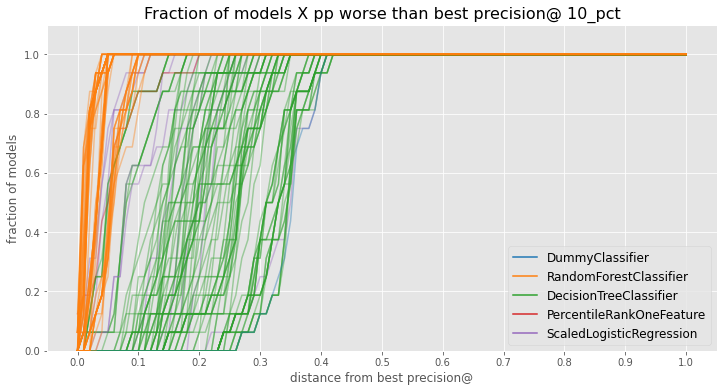

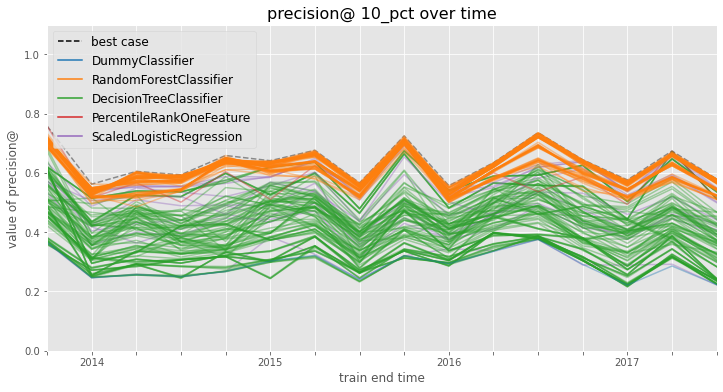

In [11]:
aud.plot_model_groups()

In [12]:
ids = aud.thresholded_model_group_ids
len(ids)

172

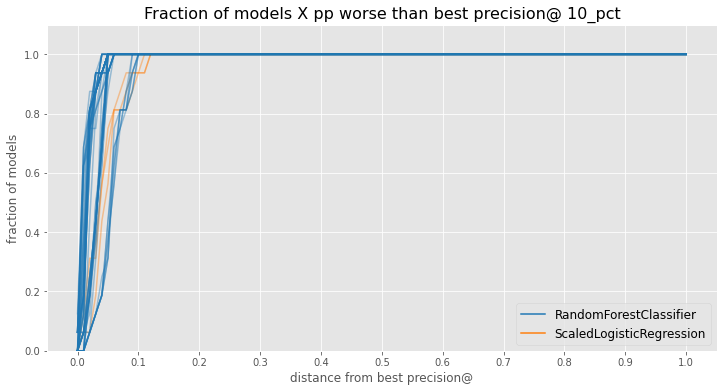

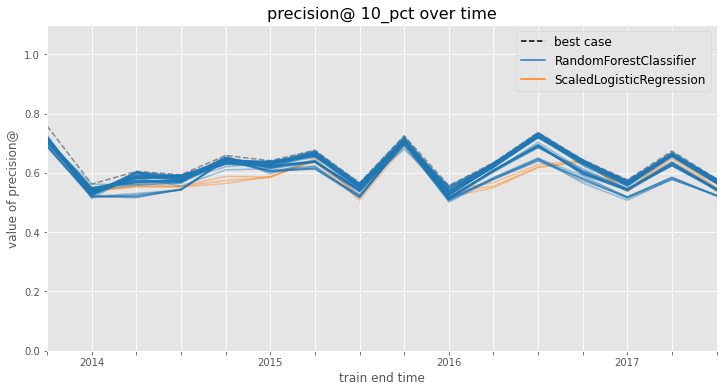

In [16]:
aud.update_metric_filters([{
    'metric': metric, 
    'parameter': parameter, 
    'max_from_best': 0.02, 
    'threshold_value': 0.5
}])

In [20]:
len(aud.thresholded_model_group_ids)

57

In [21]:
Rule1 = SimpleRuleMaker()

# if we only care about performance on the most recent test set
Rule1.add_rule_best_current_value(metric=metric, parameter=parameter, n=3)

# if we care about the average performance across all test sets
Rule1.add_rule_best_average_value(metric=metric, parameter=parameter, n=3)

# If we care about performance across all test sets, but think recent performance is more important
Rule1.add_rule_best_avg_recency_weight(metric=metric, parameter=parameter, 
                                       curr_weight=[1.5, 2.0, 5.0], decay_type=["linear"], n=3)

# If we only care about stability (regardless of performance)
Rule1.add_rule_lowest_metric_variance(metric=metric, parameter=parameter, n=3)

# If we care about how frequently the model is within a given distance from the best-performing one
Rule1.add_rule_most_frequent_best_dist(metric=metric, parameter=parameter, dist_from_best_case=[0.05], n=3)

# As a comparison point, we could also just choose a model group at random
Rule2 = RandomGroupRuleMaker(n=1)

seln_rules = create_selection_grid(Rule1, Rule2)
seln_rules

[{'shared_parameters': [{'metric': 'precision@', 'parameter': '10_pct'}],
  'selection_rules': [{'name': 'best_current_value', 'n': 3},
   {'name': 'best_average_value', 'n': 3},
   {'name': 'best_avg_recency_weight',
    'curr_weight': [1.5, 2.0, 5.0],
    'decay_type': ['linear'],
    'n': 3},
   {'name': 'lowest_metric_variance', 'n': 3},
   {'name': 'most_frequent_best_dist',
    'dist_from_best_case': [0.05],
    'n': 3}]},
 {'shared_parameters': [{}],
  'selection_rules': [{'name': 'random_model_group', 'n': 1}]}]

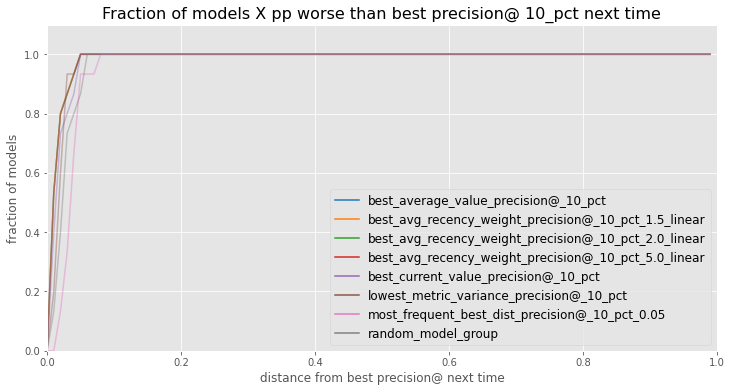

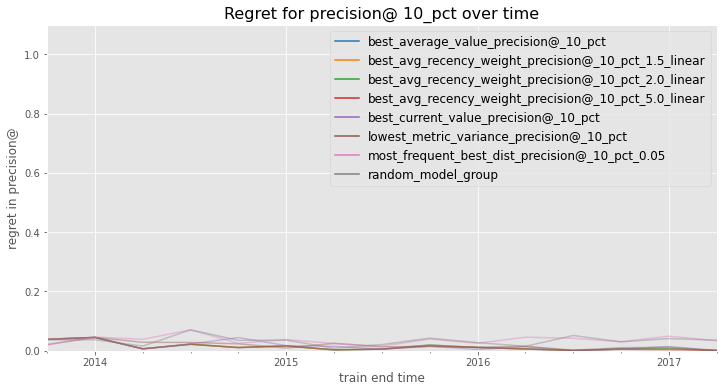

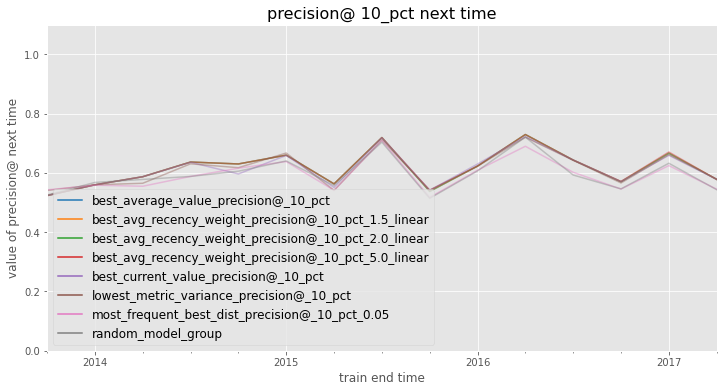

In [22]:
aud.register_selection_rule_grid(seln_rules, plot=True)

In [23]:
aud.results_for_rule[metric+parameter].head()

,train_end_time,regret,selection_rule,raw_value_next_time,model_group_id
0,2013-11-01,0.0387,best_current_value_precision@_10_pct,0.5234,1610
1,2014-02-01,0.0452,best_current_value_precision@_10_pct,0.5598,1576
2,2014-05-01,0.0067,best_current_value_precision@_10_pct,0.5871,1611
3,2014-08-01,0.0230,best_current_value_precision@_10_pct,0.6357,1615
4,2014-11-01,0.0447,best_current_value_precision@_10_pct,0.5965,1580


In [24]:
aud.selection_rule_model_group_ids

{'best_current_value_precision@_10_pct': [1613, 1611, 1604],
 'best_average_value_precision@_10_pct': [1609, 1611, 1610],
 'best_avg_recency_weight_precision@_10_pct_1.5_linear': [1609, 1611, 1610],
 'best_avg_recency_weight_precision@_10_pct_2.0_linear': [1609, 1611, 1610],
 'best_avg_recency_weight_precision@_10_pct_5.0_linear': [1609, 1611, 1610],
 'lowest_metric_variance_precision@_10_pct': [1604, 1601, 1612],
 'most_frequent_best_dist_precision@_10_pct_0.05': [1570, 1571, 1572],
 'random_model_group': [1559]}

In [26]:
q = "select distinct model_type, hyperparameters, model_group_id from triage_metadata.models where model_group_id in\
    (1613, 1611, 1604, 1609, 1610, 1601, 1612, 1570, 1571, 1572)"
ret = pd.read_sql(q, conn)

In [27]:
ret.xcol[1]

,model_type,hyperparameters,model_group_id
0,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 5, 'n_estimators': 100, 'min_sam...",1572
1,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 5, 'n_estimators': 1000, 'min_sa...",1570
2,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 5, 'n_estimators': 2500, 'min_sa...",1571
3,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 100, 'min_sa...",1604
4,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 100, 'min_sa...",1612
5,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 500, 'min_sa...",1601
6,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 500, 'min_sa...",1609
7,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 500, 'min_sa...",1613
8,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 1000, 'min_s...",1610
9,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 2500, 'min_s...",1611


In [34]:
for i in range(9):
    print(ret.loc[i]['hyperparameters'])

{'max_depth': 5, 'n_estimators': 100, 'min_samples_split': 10}
{'max_depth': 5, 'n_estimators': 1000, 'min_samples_split': 2}
{'max_depth': 5, 'n_estimators': 2500, 'min_samples_split': 2}
{'max_depth': 50, 'n_estimators': 100, 'min_samples_split': 10}
{'max_depth': 50, 'n_estimators': 100, 'min_samples_split': 50}
{'max_depth': 50, 'n_estimators': 500, 'min_samples_split': 2}
{'max_depth': 50, 'n_estimators': 500, 'min_samples_split': 25}
{'max_depth': 50, 'n_estimators': 500, 'min_samples_split': 50}
{'max_depth': 50, 'n_estimators': 1000, 'min_samples_split': 25}
